In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
import gc
import joblib 
warnings.filterwarnings("ignore")
import joblib
import pickle
from tqdm import tqdm
import random 
import lightgbm as lgb

In [2]:
sales = pd.read_csv('sales_train_evaluation.csv')
sales.name = 'sales'
calendar = pd.read_csv('calendar.csv')
calendar.name = 'calendar'
prices = pd.read_csv('sell_prices.csv')
prices.name = 'prices'


In [3]:
print(sales.shape)
print(calendar.shape)
print(prices.shape)

(30490, 1947)
(1969, 14)
(6841121, 4)


In [4]:
sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,2,1,0,0,2,1,0


In [24]:
sales.isna().sum().sum()

0

In [ ]:
sales['cat_id'].unique()

In [ ]:
sales['dept_id'].unique()

In [ ]:
sales['store_id'].unique()

In [ ]:
sales['store_id'].value_counts()

In [ ]:
prices['item_id'].nunique()

In [ ]:
#Add zero sales for the remaining days 1942-1969
for d in range(1948,1970):
    col = 'd_' + str(d)
    sales[col] = 0
    sales[col] = sales[col].astype(np.int16)
sales.shape

In [ ]:
sales.columns

In [ ]:
calendar.head()

In [ ]:
calendar.isna().sum().sum()

In [ ]:
calendar['event_type_1'].fillna('No event1',inplace = True)

In [ ]:
calendar['event_type_2'].fillna('No event2',inplace = True)

In [ ]:
calendar.tail()

In [ ]:
prices.head(10)

In [ ]:
prices.isna().sum().sum()

In [5]:
def downcast(df):
    cols = df.dtypes.index.tolist()
    types = df.dtypes.values.tolist()
    for i,t in enumerate(types):
        if 'int' in str(t):
            if df[cols[i]].min() > np.iinfo(np.int8).min and df[cols[i]].max() < np.iinfo(np.int8).max:
                df[cols[i]] = df[cols[i]].astype(np.int8)
            elif df[cols[i]].min() > np.iinfo(np.int16).min and df[cols[i]].max() < np.iinfo(np.int16).max:
                df[cols[i]] = df[cols[i]].astype(np.int16)
            elif df[cols[i]].min() > np.iinfo(np.int32).min and df[cols[i]].max() < np.iinfo(np.int32).max:
                df[cols[i]] = df[cols[i]].astype(np.int32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.int64)
        elif 'float' in str(t):
            if df[cols[i]].min() > np.finfo(np.float16).min and df[cols[i]].max() < np.finfo(np.float16).max:
                df[cols[i]] = df[cols[i]].astype(np.float16)
            elif df[cols[i]].min() > np.finfo(np.float32).min and df[cols[i]].max() < np.finfo(np.float32).max:
                df[cols[i]] = df[cols[i]].astype(np.float32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.float64)
        elif t == np.object:
            if cols[i] == 'date':
                df[cols[i]] = pd.to_datetime(df[cols[i]], format='%Y-%m-%d')
            else:
                df[cols[i]] = df[cols[i]].astype('category')
    return df  

sales = downcast(sales)
prices = downcast(prices)
calendar = downcast(calendar)

In [27]:
df = pd.melt(sales, id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name='d', value_name='sold').dropna()

In [28]:
df.shape

(59181090, 8)

In [29]:
df.columns

Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd',
       'sold'],
      dtype='object')

In [30]:
df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sold
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0


In [31]:
df = pd.merge(df, calendar, on='d', how='left')
df = pd.merge(df, prices, on=['store_id','item_id','wm_yr_wk'], how='left') 

In [32]:
df.shape

(59181090, 22)

In [33]:
df['date']=pd.to_datetime(df['date'], format='%Y-%m-%d')

In [34]:
df.shape

(59181090, 22)

As we have seen stats based model does not perform well on our data, we will do featture engineering and apply machine learning based Algoritham 

Feature engineering based on Above EDA .

In [35]:
from sklearn.preprocessing import LabelEncoder
def label_encoding(train, feature):    
    encoder = LabelEncoder()
    train[feature] = encoder.fit_transform(df[feature])
    
    return train[feature]

In [36]:
df['id']  = label_encoding(df,"id" )
df['dept_id']  = label_encoding(df,"dept_id" )
df['cat_id'] = label_encoding(df,"cat_id" )
df['store_id']  = label_encoding(df,"store_id" )
df['state_id']  = label_encoding(df,"state_id" )
df['event_type_1']  = label_encoding(df,"event_type_1" )
df['event_type_2']  = label_encoding(df,"event_type_2" )
df['event_name_1']  = label_encoding(df,"event_type_1" )
df['event_name_2']  = label_encoding(df,"event_type_2" )
df['weekday']  = label_encoding(df,"weekday" )
df['item_id']  = label_encoding(df,"item_id" )
df['wm_yr_wk']  = label_encoding(df,"wm_yr_wk" )

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59181090 entries, 0 to 59181089
Data columns (total 22 columns):
 #   Column        Dtype         
---  ------        -----         
 0   id            int32         
 1   item_id       int32         
 2   dept_id       int32         
 3   cat_id        int32         
 4   store_id      int32         
 5   state_id      int32         
 6   d             object        
 7   sold          int16         
 8   date          datetime64[ns]
 9   wm_yr_wk      int64         
 10  weekday       int32         
 11  wday          int8          
 12  month         int8          
 13  year          int16         
 14  event_name_1  int64         
 15  event_type_1  int64         
 16  event_name_2  int64         
 17  event_type_2  int64         
 18  snap_CA       int8          
 19  snap_TX       int8          
 20  snap_WI       int8          
 21  sell_price    float16       
dtypes: datetime64[ns](1), float16(1), int16(2), int32(7), int64(5), 

In [38]:
df.d = df['d'].apply(lambda x: x.split('_')[1]).astype(np.int16)

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59181090 entries, 0 to 59181089
Data columns (total 22 columns):
 #   Column        Dtype         
---  ------        -----         
 0   id            int32         
 1   item_id       int32         
 2   dept_id       int32         
 3   cat_id        int32         
 4   store_id      int32         
 5   state_id      int32         
 6   d             int16         
 7   sold          int16         
 8   date          datetime64[ns]
 9   wm_yr_wk      int64         
 10  weekday       int32         
 11  wday          int8          
 12  month         int8          
 13  year          int16         
 14  event_name_1  int64         
 15  event_type_1  int64         
 16  event_name_2  int64         
 17  event_type_2  int64         
 18  snap_CA       int8          
 19  snap_TX       int8          
 20  snap_WI       int8          
 21  sell_price    float16       
dtypes: datetime64[ns](1), float16(1), int16(3), int32(7), int64(5), 

In [40]:
shifting = 28 #shift period in order to account for 28 days to forecast
df['lag_'+str(shifting)] = df.groupby('id')['sold'].shift(shifting).astype(np.float16)

In [41]:
#Introduce lags
lags = [7,14]
for lag in lags:
    df['sold_lag_'+str(lag)] = df.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'],as_index=False)['lag_28'].shift(lag).astype(np.float16).fillna(0)

In [42]:

df['state_sold_avg'] = df.groupby('state_id')['lag_28'].transform('mean').astype(np.float16)
df['dept_sold_avg'] = df.groupby('dept_id')['lag_28'].transform('mean').astype(np.float16)
df['cat_sold_avg'] = df.groupby('cat_id')['lag_28'].transform('mean').astype(np.float16)
df['cat_daily_avg'] = df.groupby(['weekday','cat_id'])['lag_28'].transform('mean').astype(np.float16)
df['cat_monthly_avg'] = df.groupby(['month','cat_id'])['lag_28'].transform('mean').astype(np.float16)
df['cat_dept_avg'] = df.groupby(['cat_id','dept_id'])['lag_28'].transform('mean').astype(np.float16)
df['cat_dept_daily_sold_avg'] = df.groupby(['weekday','dept_id','cat_id'])['lag_28'].transform('mean').astype(np.float16)
df['cat_dept_monthly_avg'] = df.groupby(['month','dept_id','cat_id'])['lag_28'].transform('mean').astype(np.float16)


In [43]:
df['rolling_sold_mean'] = df.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])['lag_28'].transform(lambda x: x.rolling(window=7).mean()).astype(np.float16).fillna(0)

In [44]:
df['expanding_sold_mean'] = df.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])['lag_28'].transform(lambda x: x.expanding(2).mean()).astype(np.float16).fillna(0)

In [45]:
df['daily_avg_sold'] = df.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id','d'])['lag_28'].transform('mean').astype(np.float16)
df['avg_sold'] = df.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])['lag_28'].transform('mean').astype(np.float16)
df['selling_trend'] = (df['daily_avg_sold'] - df['avg_sold']).astype(np.float16)
df.drop(['daily_avg_sold','avg_sold'],axis=1,inplace=True)

In [46]:
df['sell_price'] = df['sell_price'].interpolate(method='linear', inplace=True)

#we left with 7 missing values after filling with interpolate, so fill with 0
df['sell_price'] = df['sell_price'].fillna(0) 

In [47]:
for day in range(1942,1970):
  sales['d_' + str(day)] = 0
  sales['d_' + str(day)] = sales['d_' + str(day)].astype(np.int16)

In [48]:
df.to_pickle('data_lag.pkl')
del df
gc.collect();


In [6]:
df = pd.read_pickle('data.pkl')


In [7]:
df.drop(['date','wday'],axis=1,inplace=True)

In [8]:
X_train = df[df["d"] < 1914].drop("sold", axis=1)
X_val =  df[(df['d']>=1914) & (df['d']<=1941)].drop('sold',axis=1)
X_test = df[df["d"] >= 1942].drop("sold", axis=1)

y_train = df[df["d"] < 1914]["sold"]
y_val = df[(df['d']>=1914) & (df['d']<=1941)]["sold"]

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59181090 entries, 0 to 59181089
Data columns (total 34 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   id                       int32  
 1   item_id                  int32  
 2   dept_id                  int32  
 3   cat_id                   int32  
 4   store_id                 int32  
 5   state_id                 int32  
 6   d                        int16  
 7   sold                     int16  
 8   wm_yr_wk                 int64  
 9   weekday                  int32  
 10  month                    int8   
 11  year                     int16  
 12  event_name_1             int64  
 13  event_type_1             int64  
 14  event_name_2             int64  
 15  event_type_2             int64  
 16  snap_CA                  int8   
 17  snap_TX                  int8   
 18  snap_WI                  int8   
 19  sell_price               int64  
 20  lag_28                   float16
 21  sold_l

In [10]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58327370 entries, 0 to 58327369
Data columns (total 33 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   id                       int32  
 1   item_id                  int32  
 2   dept_id                  int32  
 3   cat_id                   int32  
 4   store_id                 int32  
 5   state_id                 int32  
 6   d                        int16  
 7   wm_yr_wk                 int64  
 8   weekday                  int32  
 9   month                    int8   
 10  year                     int16  
 11  event_name_1             int64  
 12  event_type_1             int64  
 13  event_name_2             int64  
 14  event_type_2             int64  
 15  snap_CA                  int8   
 16  snap_TX                  int8   
 17  snap_WI                  int8   
 18  sell_price               int64  
 19  lag_28                   float16
 20  sold_lag_7               float16
 21  sold_l

In [11]:
df.shape

(59181090, 34)

In [ ]:
df.head()

In [11]:
X_train.shape

(58327370, 33)

In [ ]:
X_train.head()

In [12]:
prices["id"] = prices["item_id"].astype(str) + "_" + prices["store_id"].astype(str) + "_evaluation"
calendar["d"] = calendar["d"].apply(lambda a: int(a.split("_")[1]))

In [13]:
#https://www.kaggle.com/qcw171717/other-naive-forecasts-submission-score/notebook

for day in tqdm(range(1886, 1914)):  
    wk_id = list(calendar[calendar["d"]==day]["wm_yr_wk"])[0]
    wk_price = prices[prices["wm_yr_wk"]==wk_id]
    df_sales = sales.merge(wk_price[["sell_price", "id"]], on=["id"], how='inner')
    df_sales["unit_sales_" + str(day)] = df_sales["sell_price"] * df_sales["d_" + str(day)]
    df_sales.drop(columns=["sell_price"], inplace=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:11<00:00,  2.39it/s]


In [14]:
col = [a for a in df_sales.columns if a.find("unit_sales")==0]
df_sales["sales"] = df_sales[col]
df_sales["weight"] = df_sales["sales"] / df_sales["sales"].sum()
df_sales.drop(columns=["sales", col[0]], axis=1, inplace=True)
df_sales["weight"] /= 12

In [15]:
aggregation_level = {2: ["state_id"], 3: ["store_id"], 4: ["cat_id"], 5: ["dept_id"], 
              6: ["state_id", "cat_id"], 7: ["state_id", "dept_id"], 8: ["store_id", "cat_id"], 9: ["store_id", "dept_id"],
              10: ["item_id"], 11: ["item_id", "state_id"]}

In [16]:
#function to calculate rmsse 

h = 28
n = 1913

def RMSSE(ground_truth, forecast, train_series):
    
    num = ((ground_truth - forecast)**2).sum(axis=1)
    den = 1/(n-1) * ((train_series[:, 1:] - train_series[:, :-1]) ** 2).sum(axis=1)
    rmsse = (1/h * num/den) ** 0.5

    return rmsse

In [17]:
def hyperparameter_tuning(X_train, y_train, model):

    model.fit(X_train, y_train)

    for d in range(1914, 1942):
        df_sales['F_' + str(d)] = model.predict(X_val[X_val['d']==d])
    
    data = df_sales[[a for a in df_sales.columns if a.find("d_") == 0 or a.find("F_") == 0]]
    data = data.sum()

    aggregated_df = pd.DataFrame(data).transpose()    
    aggregated_df["level"] = 1
    aggregated_df["weight"] = 1/12    
    columns = aggregated_df.columns  

    for lev in aggregation_level:
        df_t = df_sales.groupby(by=aggregation_level[lev]).sum().reset_index()
        df_t["level"] = lev
        aggregated_df = aggregated_df.append(df_t[columns])     

    train_columns = [a for a in df_sales.columns if a.find("d_") == 0 and int(a.split('_')[1]) < 1914]
    actual_value_columns = [a for a in df_sales.columns if a.find("d_") == 0 and int(a.split('_')[1]) in range(1914, 1942)]
    forecast_value_columns = [a for a in df_sales.columns if a.find("F_") == 0]    

    ground_truth_df = np.array(df_sales[actual_value_columns])
    forecast_df = np.array(df_sales[forecast_value_columns])
    train_series_df = np.array(df_sales[train_columns])

    ground_truth_agg_df = np.array(aggregated_df[actual_value_columns])
    forecast_agg_df = np.array(aggregated_df[forecast_value_columns])
    train_series_agg_df = np.array(aggregated_df[train_columns])

    df_sales["rmsse"] = RMSSE(ground_truth_df, forecast_df, train_series_df)
    aggregated_df["rmsse"] = RMSSE(ground_truth_agg_df, forecast_agg_df, train_series_agg_df)

    df_sales["wrmsse"] = df_sales["weight"] * df_sales["rmsse"]
    aggregated_df["wrmsse"] = aggregated_df["weight"] * aggregated_df["rmsse"]

    print(df_sales["wrmsse"].sum() + aggregated_df["wrmsse"].sum())
    
    return (df_sales["wrmsse"].sum() + aggregated_df["wrmsse"].sum())

In [18]:
%%time

wrmsse=[]
lr=[]
n_leaves=[]
min_d_leaf=[]

for _ in tqdm(range(15)):

    learning_rate = random.randint(25, 75)/1000
    num_leaves = random.randint(32, 128)
    min_data_in_leaf = random.randint(50, 150)

    print(learning_rate)
    print(num_leaves)
    print(min_data_in_leaf)
    
    model = lgb.LGBMRegressor(learning_rate= learning_rate,num_leaves=num_leaves,min_data_in_leaf=min_data_in_leaf)
    
    WRMSSE = hyperparameter_tuning(X_train, y_train, model)

    wrmsse.append(WRMSSE)
    lr.append(learning_rate)
    n_leaves.append(num_leaves)
    min_d_leaf.append(min_data_in_leaf)

  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

0.057
35
95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95


  7%|█████▎                                                                          | 1/15 [08:43<2:02:11, 523.67s/it]

0.86319950510302
0.034
112
87
[LightGBM] [Warning] min_data_in_leaf is set=87, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=87


 13%|██████████▋                                                                     | 2/15 [19:09<2:06:31, 583.98s/it]

0.8975298905815252
0.029
86
84
[LightGBM] [Warning] min_data_in_leaf is set=84, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=84


 20%|████████████████                                                                | 3/15 [27:49<1:50:54, 554.50s/it]

0.9396364303311228
0.029
110
107
[LightGBM] [Warning] min_data_in_leaf is set=107, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=107


 27%|█████████████████████▎                                                          | 4/15 [36:32<1:39:25, 542.30s/it]

0.934092591492102
0.037
119
55
[LightGBM] [Warning] min_data_in_leaf is set=55, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=55


 33%|██████████████████████████▋                                                     | 5/15 [44:53<1:27:54, 527.43s/it]

0.8819931875373463
0.042
102
148
[LightGBM] [Warning] min_data_in_leaf is set=148, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=148


 40%|████████████████████████████████                                                | 6/15 [52:53<1:16:41, 511.27s/it]

0.8541924371857251
0.059
40
68
[LightGBM] [Warning] min_data_in_leaf is set=68, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=68


 47%|█████████████████████████████████████▎                                          | 7/15 [59:38<1:03:31, 476.48s/it]

0.8343452214695017
0.074
47
88
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88


 53%|██████████████████████████████████████████▋                                     | 8/15 [1:06:16<52:40, 451.54s/it]

0.785007926047836
0.026
34
123
[LightGBM] [Warning] min_data_in_leaf is set=123, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=123


 60%|████████████████████████████████████████████████                                | 9/15 [1:13:31<44:38, 446.34s/it]

1.0133054355696496
0.056
62
62
[LightGBM] [Warning] min_data_in_leaf is set=62, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=62


 67%|████████████████████████████████████████████████████▋                          | 10/15 [1:20:52<37:02, 444.51s/it]

0.8197801550762879
0.067
77
103
[LightGBM] [Warning] min_data_in_leaf is set=103, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=103


 73%|█████████████████████████████████████████████████████████▉                     | 11/15 [1:28:07<29:27, 441.76s/it]

0.7787608500298726
0.047
86
80
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80


 80%|███████████████████████████████████████████████████████████████▏               | 12/15 [1:35:52<22:26, 448.67s/it]

0.8458755566743315
0.069
66
96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96


 87%|████████████████████████████████████████████████████████████████████▍          | 13/15 [1:43:10<14:51, 445.59s/it]

0.7771485919327373
0.038
60
108
[LightGBM] [Warning] min_data_in_leaf is set=108, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=108


 93%|█████████████████████████████████████████████████████████████████████████▋     | 14/15 [1:50:52<07:30, 450.61s/it]

0.8947554999771842
0.032
91
141
[LightGBM] [Warning] min_data_in_leaf is set=141, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=141


100%|███████████████████████████████████████████████████████████████████████████████| 15/15 [1:59:25<00:00, 477.70s/it]

0.9134367571099689
Wall time: 1h 59min 25s


In [19]:
minpos = wrmsse.index(min(wrmsse))
learning_rate = lr[minpos]
num_leaves = n_leaves[minpos]
min_data_in_leaf = min_d_leaf[minpos]

In [20]:
#fit the model on best parameters

m_lgb = lgb.LGBMRegressor( learning_rate=learning_rate ,
                           num_leaves=num_leaves ,
                           min_data_in_leaf=min_data_in_leaf)

m_lgb.fit(X_train, y_train)

[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96


LGBMRegressor(learning_rate=0.069, min_data_in_leaf=96, num_leaves=66)

In [21]:
with open('model_lgb_2', 'wb') as file:
        pickle.dump(m_lgb, file)

In [22]:
for d in range(1914, 1942):
    df_sales['F_' + str(d)] = m_lgb.predict(X_val[X_val['d']==d])

In [23]:
def WRMSSE(df_sales):

  aggregation_level = {2: ["state_id"], 3: ["store_id"], 4: ["cat_id"], 5: ["dept_id"], 
              6: ["state_id", "cat_id"], 7: ["state_id", "dept_id"], 8: ["store_id", "cat_id"], 9: ["store_id", "dept_id"],
              10: ["item_id"], 11: ["item_id", "state_id"]}

  data = df_sales[[a for a in df_sales.columns if a.find("d_") == 0 or a.find("F_") == 0]]
  data = data.sum()

  aggregated_df = pd.DataFrame(data).transpose()    
  aggregated_df["level"] = 1
  aggregated_df["weight"] = 1/12    
  columns = aggregated_df.columns  

  for lev in aggregation_level:
      df_t = df_sales.groupby(by=aggregation_level[lev]).sum().reset_index()
      df_t["level"] = lev
      aggregated_df = aggregated_df.append(df_t[columns])     

  #print(df_sales.shape[0], aggregated_df.shape[0], df_sales.shape[0] + aggregated_df.shape[0])
  #print(aggregated_df["weight"].sum() + df_sales["weight"].sum())    

  train_columns = [a for a in df_sales.columns if a.find("d_") == 0 and int(a.split('_')[1]) < 1914]
  actual_value_columns = [a for a in df_sales.columns if a.find("d_") == 0 and int(a.split('_')[1]) in range(1914, 1942)]
  forecast_value_columns = [a for a in df_sales.columns if a.find("F_") == 0]    


  ground_truth_df = np.array(df_sales[actual_value_columns])
  forecast_df = np.array(df_sales[forecast_value_columns])
  train_series_df = np.array(df_sales[train_columns])

  ground_truth_agg_df = np.array(aggregated_df[actual_value_columns])
  forecast_agg_df = np.array(aggregated_df[forecast_value_columns])
  train_series_agg_df = np.array(aggregated_df[train_columns])

  df_sales["rmsse"] = RMSSE(ground_truth_df, forecast_df, train_series_df)
  aggregated_df["rmsse"] = RMSSE(ground_truth_agg_df, forecast_agg_df, train_series_agg_df)

  df_sales["wrmsse"] = df_sales["weight"] * df_sales["rmsse"]
  aggregated_df["wrmsse"] = aggregated_df["weight"] * aggregated_df["rmsse"]

  print("df", df_sales["wrmsse"].sum())
  print("agg_df",aggregated_df["wrmsse"].sum())

  WRMSSE = df_sales["wrmsse"].sum() + aggregated_df["wrmsse"].sum()
  #print(WRMSSE)

  return WRMSSE 

In [24]:
WRMSSE(df_sales)

df 0.08828533408389352
agg_df 0.6888632578488438


0.7771485919327373

In [25]:
with open("model_lgb_2",'rb') as files:
    lgb_model= pickle.load(files)

In [26]:
df_feature_importance = (
    pd.DataFrame({
        'feature': X_train.columns,
        'importance': lgb_model.feature_importances_,
    })
    .sort_values('importance', ascending=False)
)

<AxesSubplot:xlabel='importance', ylabel='feature'>

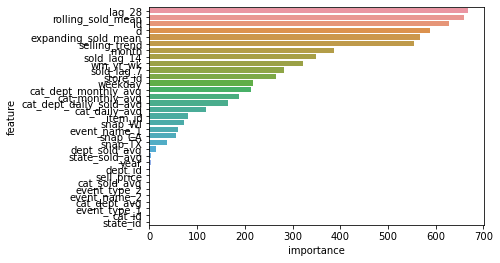

In [27]:
sns.barplot(x="importance", y="feature",data=df_feature_importance)

In [29]:
def final_func_1(X):
    #here we are inserting the columns for the days d_1942 to d_1969 as nan for which we need to forecast sales
    for day in range(1942,1970):
       X['d_' + str(day)] = 0
       X['d_' + str(day)] = sales['d_' + str(day)].astype(np.int16)
    
    #to transform the dataframe into vertical rows as each corresponds to each day sales of an item from a particular store
    X_melt = pd.melt(X, id_vars=['id','item_id','dept_id','cat_id','store_id','state_id'],
                       var_name='d',value_name='sales')
    #creating a single dataframe
    X_melt = X_melt.merge(calendar_df,  on='d', how='left')
    X_melt = X_melt.merge(prices_df, on=['store_id','item_id','wm_yr_wk'], how='left')
    
    #pre processing missing values of prices by transforming with mean price of that id
    X_melt['sell_price'].fillna(X_melt.groupby('id')['sell_price'].transform('mean'),inplace=True)
       
    def label_encoding(train, feature):    
       encoder = LabelEncoder()
       train[feature] = encoder.fit_transform(df[feature])
       return train[feature]

    shifting = 28 #shift period in order to account for 28 days to forecast
    X_melt['lag_'+str(shifting)] = X_melt.groupby('id')['sold'].shift(shifting).astype(np.float16)
    X_melt['dept_id']  = label_encoding(X_melt,"dept_id" )
    X_melt['cat_id'] = label_encoding(X_melt,"cat_id" )
    X_melt['store_id']  = label_encoding(X_melt,"store_id" )
    X_melt['state_id']  = label_encoding(X_melt,"state_id" )
    X_melt['event_type_1']  = label_encoding(X_melt,"event_type_1" )
    X_melt['event_type_2']  = label_encoding(X_melt,"event_type_2" )
    X_melt['event_name_1']  = label_encoding(X_melt,"event_type_1" )
    X_melt['event_name_2']  = label_encoding(X_melt,"event_type_2" )
    X_melt['weekday']  = label_encoding(X_melt,"weekday" )
    X_melt['item_id']  = label_encoding(X_melt,"item_id" )
    X_melt['wm_yr_wk']  = label_encoding(X_melt,"wm_yr_wk" )
    #Introduce lags
    lags = [7,14]
    for lag in lags:
       X_melt['sold_lag_'+str(lag)] = X_melt.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'],as_index=False)['lag_28'].shift(lag).astype(np.float16).fillna(0)
    X_melt['state_sold_avg'] = X_melt.groupby('state_id')['lag_28'].transform('mean').astype(np.float16)
    X_melt['dept_sold_avg'] = X_melt.groupby('dept_id')['lag_28'].transform('mean').astype(np.float16)
    X_melt['cat_sold_avg'] = X_melt.groupby('cat_id')['lag_28'].transform('mean').astype(np.float16)
    X_melt['cat_daily_avg'] = X_melt.groupby(['weekday','cat_id'])['lag_28'].transform('mean').astype(np.float16)
    X_melt['cat_monthly_avg'] = X_melt.groupby(['month','cat_id'])['lag_28'].transform('mean').astype(np.float16)
    X_melt['cat_dept_avg'] = X_melt.groupby(['cat_id','dept_id'])['lag_28'].transform('mean').astype(np.float16)
    X_melt['cat_dept_daily_sold_avg'] = X_melt.groupby(['weekday','dept_id','cat_id'])['lag_28'].transform('mean').astype(np.float16)
    X_melt['cat_dept_monthly_avg'] = X_melt.groupby(['month','dept_id','cat_id'])['lag_28'].transform('mean').astype(np.float16)
    



    




    
    X_pre = X_melt.drop(['sales','date','weekday','wm_yr_wk'],axis=1)
    predictions_df = pd.DataFrame()
    model= joblib.load('model_lgb_1.pkl')
    
    predictions = model.predict(X_pre_pred.values)
    #slicing the predictions such that to get each day predictions of all the products of test data
    start = 0
    t = int(X_pre.iloc[0]['d'])
    while start < len(predictions):
        end = start + 1
        predictions_df['d_'+str(t)] = predictions[start:end]
        start = end
        t = t+1
    predictions_df = pd.concat([X['id'],predictions_df],axis=1,sort=False)
    predictions_df_val = predictions_df[['id']]
    #validation predictions from days 1914-1941
    for i in range(28):
        predictions_df_val['F'+str(i+1)] = predictions_df['d_'+str(1914+i)]
    predictions_df_val['id'] =  predictions_df_val['id'].apply(lambda x: x.replace('evaluation','validation'))
    predictions_df_eval = predictions_df_val.copy()
    #evaluation predictions from days 1942-1969
    for i in range(28):
        predictions_df_eval['F'+str(i+1)] = predictions_df['d_'+str(1942+i)]
    predictions_df_eval["id"] = predictions_df_eval["id"].apply(lambda x: x.replace('validation','evaluation'))
    final_predictions = predictions_df_val.append(predictions_df_eval).reset_index(drop=True)
    return final_predictions
